# Effect of fixing the number of training samples

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
import seaborn as sns

In [2]:
sys.path.append("..") 
from rcgfd import RCDataset, plot_ke_relerr, MetricsPlot, SingleTimePlot, global_legend

In [3]:
plt.style.use("./rc-gfd.mplstyle")

In [4]:
fig_dir = "../figures"
if not os.path.isdir(fig_dir):
    os.makedirs(fig_dir)

In [5]:
class FixedStepsRCDataset(RCDataset):
    fix_factor = None
    use_original_dataset = True
    
    def __init__(self, **kwargs):
        self.fix_factor = kwargs.pop("fix_factor", None)
        self.fix_factor = (self.fix_factor,) if not isinstance(self.fix_factor, (list, tuple)) else self.fix_factor
        super().__init__(**kwargs)
    
    def __call__(self):
        dslist = []
        for n_sub in self.n_sub:
            dslist2 = []
            for ct in self.cost_terms:
                dslist3 = []
                for ff in self.fix_factor:
                    dslist3.append( self.open_single_dataset(ct, n_sub, ff) )
                dslist2.append(xr.concat(dslist3, dim="fix_factor"))
            dslist.append(xr.concat(dslist2, dim="cost_terms"))
        
        xds = xr.concat(dslist, dim="n_sub")
        xds = self.postprocess_dataset(xds)
        return xds
        
    
    def expand_dims(self, xds, main_dir, n_sub, fix_factor):
        xds = super().expand_dims(xds, main_dir, n_sub)
        xds = xds.expand_dims({"fix_factor": [fix_factor]})
        return xds
    
    def get_results_path(self, cost, n_sub, this_ff):
        main_dir, fname = super().get_results_path(cost, n_sub)
        fname = fname.replace("validation", f"fixed-steps-{this_ff:02d}-validation")
        if not self.use_original_dataset:
            fname = fname.replace("fixed-steps", f"fixed-steps-long")
        if self.use_original_dataset and this_ff == 16 and n_sub == 16:
            # Then undo everything lol
            fname = fname.replace("fixed-steps-16-", "")
            
        return main_dir, fname
        
    
    def open_single_dataset(self, this_cost, n_sub, this_ff):
        main_dir, fname = self.get_results_path(this_cost, n_sub, this_ff)
        
        xds = xr.concat([
            xr.open_zarr(fname.replace("results", f"results.{i:03d}"), chunks=self.chunks) for i in range(self.n_samples)
        ],
            dim="sample",
            coords="minimal")
        
        xds = self.renormalize_dataset(xds, fname)
        xds = self.expand_dims(xds, main_dir, n_sub, this_ff)
        return xds

In [6]:
frcd = FixedStepsRCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        #{"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        #{"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        #{"nrmse": 1, "spectral": 1.0},
    ],
    fix_factor=16,
)
dsf = frcd()

In [7]:
rcd = RCDataset(
    n_sub=[1, 4, 16],
    cost_terms = [
        #{"nrmse": 1},
        #{"nrmse": 1, "spectral": 1e-3},
        #{"nrmse": 1, "spectral": 1e-2},
        {"nrmse": 1, "spectral": 1e-1},
        #{"nrmse": 1, "spectral": 1.0},
    ],
)
dsn = rcd().expand_dims({"fix_factor": [0]})

In [8]:
dsn["truth"] = dsn["truth"].isel(fix_factor=0)

In [9]:
ds = xr.concat([dsn,dsf], dim="fix_factor")

In [10]:
stp = SingleTimePlot(diff_t0=False, time=4*3600)

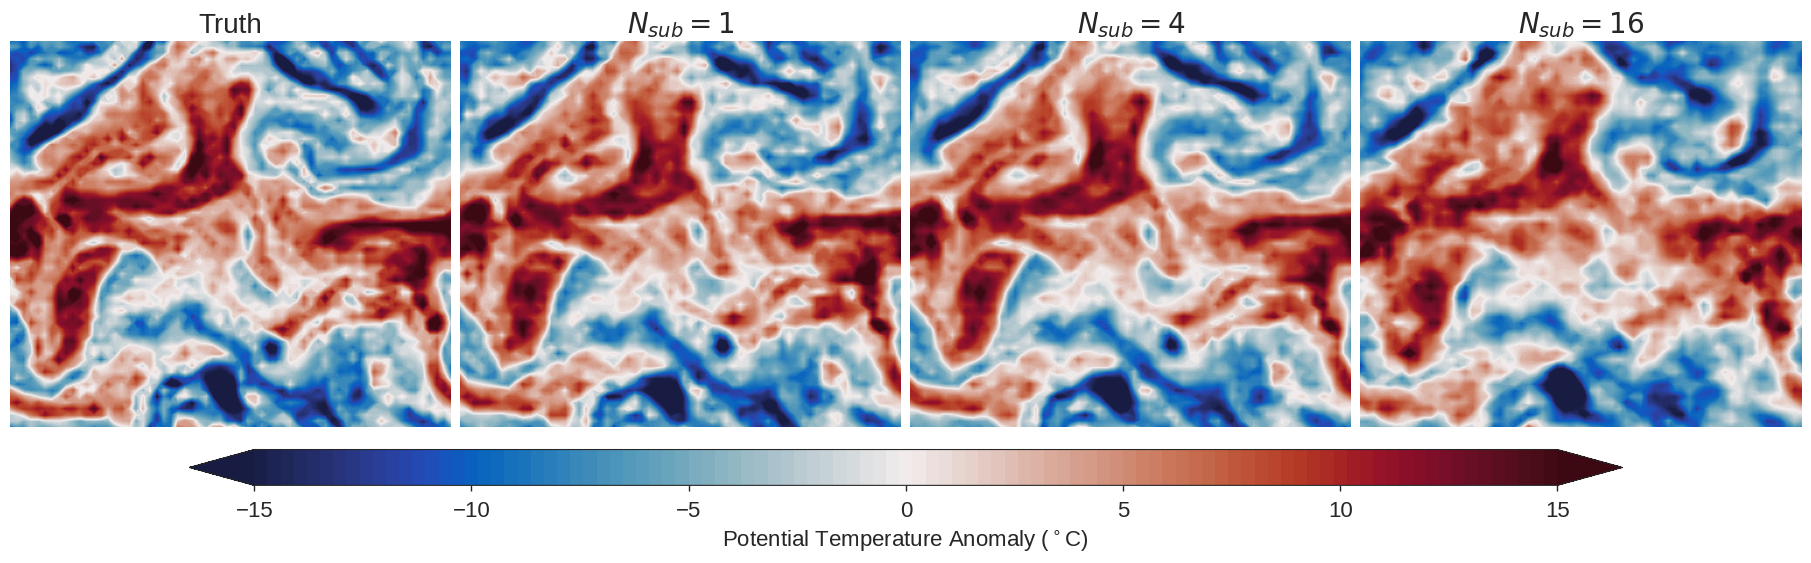

In [11]:
fig, axs = fig, axs = stp(ds.sel(fix_factor=16, sample=49), col_dim="n_sub")
[ax.set(title=r"$N_{sub} = %d$" % n_sub) for n_sub, ax in zip(ds.n_sub.values, axs[1:])];

## Metrics

In [12]:
ds['nrmse'].load();
ds["p_nrmse"].load();

In [13]:
mp = MetricsPlot(
    metrics=("nrmse", "ke_nrmse", "ke_nrmse"),
    cdim="n_sub",
    show_persistence=True,
    estimator="median",
)

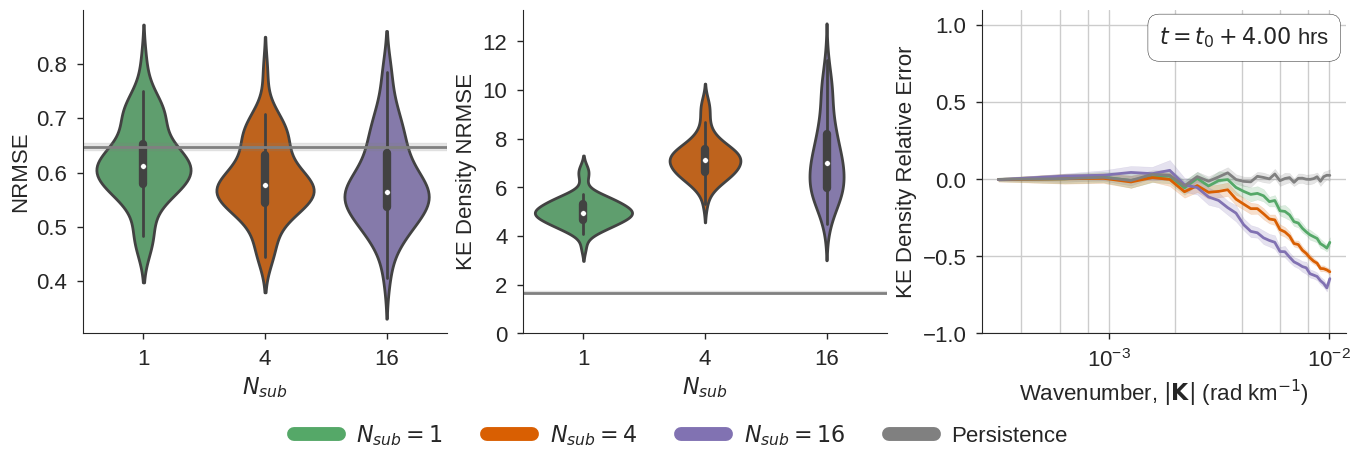

In [14]:
fig, axs = mp(ds.sel(fix_factor=16), show_time=False)#, hue="fix_factor", split=True)
[ax.set(xlabel="$N_{sub}$") for ax in axs[:-1]]
[ax.legend().remove() for ax in axs]
axs[1].set(ylim=(0,None))
axs[-1].clear()

fig, axs = plot_ke_relerr(
    ds["ke_rel_err"].sel(fix_factor=16),
    fig=fig,
    axs=axs[-1:],
    hours=(4,),
    cdim="n_sub",
    show_persistence=True,
    persistence=ds["p_ke_rel_err"]
)
labels = [
    mp.n_sub_label(x) for x in [1,4,16]
]
labels.append("Persistence")
global_legend(fig, labels, color_start=mp.color_start)

fig.savefig(f"{fig_dir}/rc_fixed_steps.pdf", bbox_inches="tight")

In [19]:
kenrmse = (ds.ke_nrmse.sel(fix_factor=16)**2).mean("time")
kenrmse = np.sqrt(kenrmse)

In [20]:
from statistics import median

In [21]:
for n_sub in ds.n_sub.values:
    print(f"Nsub: {n_sub}")
    print(f"  median: {median(kenrmse.sel(n_sub=n_sub).values):.02f}")
    print(f"  avg: {kenrmse.sel(n_sub=n_sub).mean('sample').values:.02f}")

Nsub: 1
  median: 4.96
  avg: 5.03
Nsub: 4
  median: 7.13
  avg: 7.19
Nsub: 16
  median: 7.00
  avg: 7.23
